<a href="https://colab.research.google.com/github/ajaynain-eng/Hyperspectral-Image-Classification/blob/main/372_Resnet_ps7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Working with ResNet**

In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 19.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.stats as st
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import os
import gc
import math
import threading

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Add,Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate, Lambda
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling2D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, add, multiply
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

import spectral

np.random.seed(1337)          # to get reproducible results
folder_path = "/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/ResNet"

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at : ', device_name)

Found GPU at :  /device:GPU:0


In [ ]:
H, W, B = 1101, 566, 372             # height,width and band of image
# keep ps=7 in this file
P_S = 7                          # patch size (window size)
train_percent = 75
epochs = 300
weight_decay=5e-4
use_pearson_corr = False           #True

In [ ]:
mat_x = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full.mat')['full']           # shape 623166*372
mat_y = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full_gt.mat')['full_gt']     # shape 623166*1
# selective_bands = [0, 53, 56, 70, 71, 103, 106, 113, 115, 116, 117, 142, 174, 188, 195, 198, 200, 201, 203, 205, 207, 238, 239, 254, 264, 266, 272, 274, 281, 282, 
#                    284, 285, 292, 293, 296, 298, 301, 303, 310, 313, 315, 337, 341, 342, 343, 345, 346, 349, 369]

mat_x[mat_x < 0.0] = 0.0
mat_x[mat_x > 1.0] = 1.0
print("minimum value in mat_x is :", mat_x.min())
print("maximum value in mat_x is :", mat_x.max())
# mat_x = mat_x[:, selective_bands]
x, y = np.array(mat_x), np.array(mat_y)
x, y = x.reshape(H,W,B), y.reshape(H,W)


x = x.astype('float16')
# for i in range(B):
#   x[:,:,i] /= np.max(x[:,:,i])

pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')
# np.save("/content/drive/MyDrive/Personal Folder for training/padded_x.npy" , padded_x)
X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

output_classes = len(np.unique(y))-1

print("\n")
print("shape of mat_x: ", mat_x.shape)
print("shape of mat_y: ", mat_y.shape)
print("shape of x: ", x.shape)
print("shape of y: ", y.shape)

minimum value in mat_x is : 0.0
maximum value in mat_x is : 1.0


shape of mat_x:  (623166, 372)
shape of mat_y:  (623166, 1)
shape of x:  (1101, 566, 372)
shape of y:  (1101, 566)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split( X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train,x_test,y_train,y_test = np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 668,  128,  192,  337,  259,  174,  753,  181,  190,  404, 1033,
        404, 1163]))


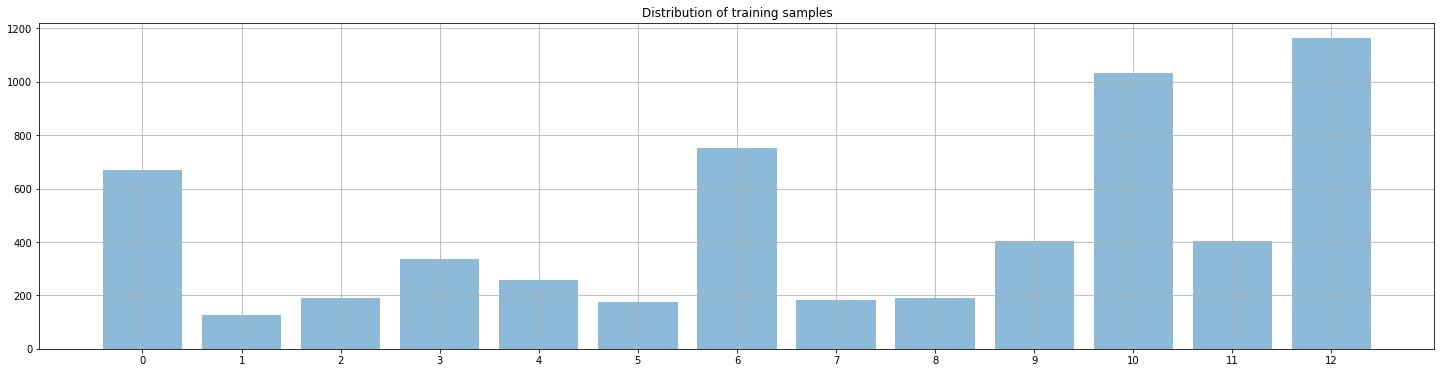

In [ ]:
plt.figure(figsize = (25, 6))
u_c = np.unique(y_train,return_counts=True)
print(u_c)
plt.bar( u_c[0],u_c[1], align='center', alpha=0.5)
plt.title('Distribution of training samples')
plt.xticks(np.arange(0,u_c[0].shape[0]))
plt.grid()
plt.show()

In [ ]:
# del un-necessary data as it is consuming around 3 GB of RAM
del mat_x, mat_y, x, y, X, Y

In [ ]:
print("shape of x_train is: ", x_train.shape)
print("shape of x_test is:  ", x_test.shape)
print("shape of y_train is: ", y_train.shape)
print(" shape of y_test is: ", y_test.shape)

shape of x_train is:  (5886, 7, 7, 372)
shape of x_test is:   (1963, 7, 7, 372)
shape of y_train is:  (5886,)
 shape of y_test is:  (1963,)


## **Defining Functions**

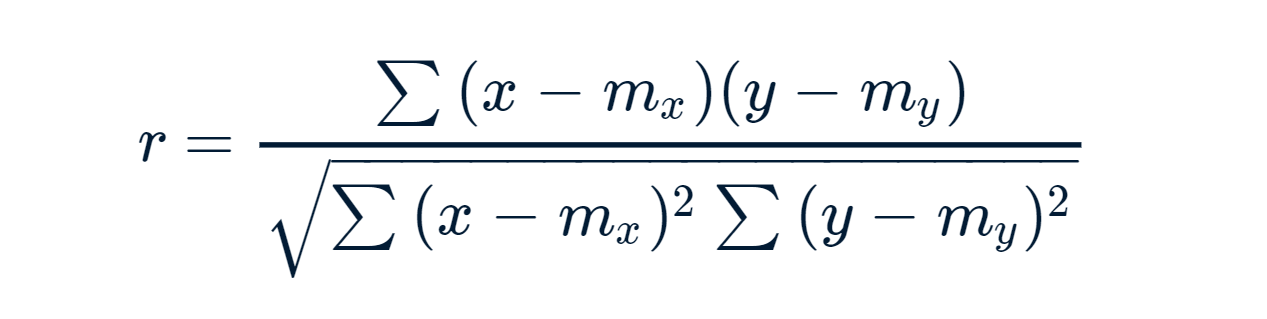

In [ ]:
def masked_correlation(gus_k, X, channels = 64, P_S = 11):
    loc = P_S//2
# Working as per the above formula to calculate Pearson correlation coefficient.
# For all the operations I have avoided any kind of loop as loops are slow (written in python). Numpy array (written in C) and Tensors are very fast.
# Here we are interested to use highly correlated spatial information around central pixels. we will consider the surrounding spatial information based on their correlation

    x_mean = tf.math.reduce_mean(X, axis = -1, keepdims=True)
    x_mean = tf.repeat(x_mean, repeats = channels, axis = -1)

    y = X[:,loc:loc+1, loc:loc+1, :]
    y = tf.repeat(y, repeats = P_S, axis = -2)
    y = tf.repeat(y, repeats = P_S, axis = -3)

    y_mean = tf.math.reduce_mean(y, axis = -1, keepdims = True)
    y_mean = tf.repeat(y_mean, repeats = channels, axis = -1)

    a = tf.math.subtract(X, x_mean)
    b = tf.math.subtract(y, y_mean)
    ab = tf.math.multiply(a,b)
    num = tf.math.reduce_sum(ab, axis = -1, keepdims = True)                        # Numerator

    a_new = tf.math.reduce_sum(tf.math.multiply(a,a), axis = -1, keepdims = True)
    b_new = tf.math.reduce_sum(tf.math.multiply(b,b), axis = -1, keepdims = True)
    deno = tf.math.sqrt(tf.math.multiply(a_new, b_new))                             # Denominator
 
    corr = tf.math.divide(num, deno)                                                # Pearson correlation coefficient

    thresh = tf.math.reduce_mean(corr)                                      # Consider the surrounding spatial info showing correlation value higher than a certain threshold.
    mask = corr > thresh                                                    # Forming a mask for selecting spatial information [1 if to select otherwise 0 ]
    mask = tf.cast(mask, corr.dtype)

    masked_corr = tf.math.multiply(mask, corr)
    # gus_k = tf.expand_dims(gus_k, axis = -1) 
    # gus_k = gus_k.reshape(P_S, P_S, 1)                     
    # masked_corr = tf.math.multiply(masked_corr, gus_k)          # Further scaling the selected spatial information based on their distance from centre (apply gaussion filter)
  
    attention_weights = tf.repeat(masked_corr, repeats = channels, axis = -1)
    X = Multiply()([X, attention_weights])
    return X

In [ ]:
def Spatial_attention_0(x, filter):
    shape = x.shape
    x = Conv2D(filters=1, kernel_size=(1,1), padding='same')(x) # to aggregate the Spatial information. Generating 2D feature map.
    x = BatchNormalization()(x)
    # Applying 2D convolution to derive a spatial attention.
    x = Conv2D(filters=1, kernel_size=(7,7), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1, kernel_size=(5,5), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1, kernel_size=(3,3), padding='same')(x)
    x = Activation('sigmoid')(x) 
    # x = Conv2D(filters = filter, kernel_size=(1,1), kernel_initializer=Ones())(x)
    x = tf.repeat(x, repeats = filter, axis = -1)
    # Sigmoid is used as activation so that pixel with very less information can be converted to nearby zero and highly important to nearly 1
    # Further multiplication with initial spatial features will keep highly important features and minimize the others less important features to zero (approx)
    return x

def Spatial_attention(x, filter):
    input = x
    shape = x.shape
    # x = Conv2D(filters=filter, kernel_size=(1,1), padding='same')(x)
    # x = BatchNormalization()(x)
    # Applying 2D convolution to derive a spatial attention.
    x = Conv2D(filters=filter, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)     # kernel_regularizer=l2(5e-4)
    x = BatchNormalization(axis=-1)(x)
    x_0 = Activation('relu')(x)

    x = Conv2D(filters=filter, kernel_size=(3,3), strides = (2,2), padding='same')(x_0)
    x = Activation('relu')(x)

    x = Conv2D(filters=1, kernel_size=(3,3), strides = (2,2), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=filter, kernel_size=(3,3), strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=filter, kernel_size=(3,3), strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x)
    if shape != x.shape:
        k_size = x.shape[-3] - shape[-3] + 1
        x = Conv2D(filter, kernel_size=k_size, strides=(1, 1), padding='valid')(x)
    else:
        pass
    x = Activation('sigmoid')(x) 
    # x = Conv2D(filters = filter, kernel_size=(1,1), kernel_initializer=Ones())(x)
    # x = tf.repeat(x, repeats = filter, axis = -1)
    # Sigmoid is used as activation so that pixel with very less information can be converted to nearby zero and highly important to nearly 1
    # Further multiplication with initial spatial features will keep highly important features and minimize the others less important features to zero (approx)
    x = Multiply()([input, x])
    # x = add([output, input])
    return x

In [ ]:
def channel_attention_block(input, filters, kernel_size, padding, reduction_ratio, weight_decay=5e-4):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_initializer='he_normal')(input)    # kernel_regularizer=l2(weight_decay)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    squeeze = GlobalAveragePooling2D(keepdims=True)(x)

    # excitation = Reshape((1, 1, filters))(squeeze)
    excitation = Conv2D(filters=filters//reduction_ratio, kernel_size=1, use_bias=False, kernel_initializer='he_normal')(squeeze)
    excitation = Activation('relu')(excitation)
    excitation = Conv2D(filters=filters, kernel_size=1, use_bias=False, kernel_initializer='he_normal')(excitation)
    excitation = Activation('sigmoid')(excitation)

    x = multiply([input, excitation])

    # x_add = add([x, input])

    return x
 
def Spectral_attention(input, filters, cardinality = 8):
    shape = input.shape
    group_list = []
    grouped_channels = shape[-1]//cardinality        # As some bands/channels may be more important than their neighbours and at the same time less important than distants.
    for c in range(cardinality):                     # We will consider band importance in their neighbours (generate subsets of bands and then apply attention)
        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels])(input)
        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(1, 1), kernel_initializer='he_normal')(x)
        x_channel = channel_attention_block(x, filters=grouped_channels, kernel_size=3, padding='same', reduction_ratio=2)
        group_list.append(x_channel)

    group_merge = concatenate(group_list, axis=-1)
    x = BatchNormalization(axis=-1)(group_merge)
#    x = UpSampling2D(size=(shape[1], shape[2]))(x) # Upsample the array to match the origional feature metrix
    return x

def Spectral_attention_0 (x, filters):
    shape = x.shape
    # Averagepooling the features along channel. (shape = 1*1*channels or bands). 1D vector representing bands info.
    # Now we have 1 value per channel/band. After training we would have high value in vector corresponding to highly important band.
    x = GlobalAveragePooling2D(data_format='channels_last', keepdims=True)(x)
    x = Conv2D(filters=filters, kernel_size=(1,1))(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=(1,1))(x)
    x = Activation('sigmoid')(x)
    # Sigmoid is used as activation so that value in vector corresponding to different bands can be altered as per their importance.
    x = UpSampling2D(size=(shape[1], shape[2]))(x) # Upsample the array to match the origional feature metrix
    return x

#**Copy1 End**

In [ ]:
def apply_attention(X, Spe_A, Spa_A):
    F_A = Multiply()([X, Spe_A])  # Multiplication operation will generate scaled output based on Spectral importance
    F_B = Multiply()([X, Spa_A])  # Multiplication operation will generate scaled output based on Spatial importance
        # X = Add()([X, F_A, F_B])      # Adding all the output(convolution, Spectral, Spatial) from the block
    X = Add()([F_A, F_B])
    X = BatchNormalization()(X)
    return X

In [ ]:
# def identity_block_with_attention(X, f, filters):

#     # Retrieve Filters
#     F1, F2, F3 = filters

#     # Save the input value
#     X_shortcut = X

#     ##### MAIN PATH #####
#     # First component of main path 
#     X = Conv2D(filters=F1, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     Spe_A = Spectral_attention(X, F3)
#     Spa_A = Spatial_attention(X, F3)

#     # Second component of main path
#     X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     # Third component of main path
#     X = Conv2D(filters=F3, kernel_size=(f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3)(X)

#     # Final step: Add shortcut value to main path, and pass it through a RELU activation
#     X = Add()([X, X_shortcut]) 
#     X = Activation('relu')(X)

#     return X, Spe_A, Spa_A

def identity_block_with_attention(X, f, filters):

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation

    X_shortcut = Spectral_attention(X_shortcut, F3)
    X_shortcut = Spatial_attention(X_shortcut, F3)
    # Spe_A = Spectral_attention(X, F3)
    # Spa_A = Spatial_attention(X, F3)
    # X = apply_attention(X, Spe_A, Spa_A)
    
    X = Add()([X, X_shortcut])
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)

    return X


def identity_block(X, f, filters):

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)

    return X

In [ ]:
# def convolutional_block_with_attention(X, f, filters):

#     # Retrieve Filters
#     F1, F2, F3 = filters

#     # Save the input value
#     X_shortcut = X

#     ##### MAIN PATH #####
#     # First component of main path 
#     X = Conv2D(filters=F1, kernel_size = (f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     Spe_A = Spectral_attention(X, F3)
#     Spa_A = Spatial_attention(X, F3)

#     # Second component of main path
#     X = Conv2D(filters=F2, kernel_size = (f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     # Third component of main path
#     X = Conv2D(filters=F3, kernel_size = (f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     ##### SHORTCUT PATH #### 
#     X_shortcut = Conv2D(filters=F3, kernel_size = (f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
#     X_shortcut = BatchNormalization(axis=3)(X_shortcut)

#     # Final step: Add shortcut value to main path, and pass it through a RELU activation
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)

#     return X, Spe_A, Spa_A

def convolutional_block_with_attention(X, f, filters):

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size = (f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size = (f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size = (f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size = (f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=-1)(X_shortcut)
    X_shortcut = Spectral_attention(X_shortcut, F3)
    X_shortcut = Spatial_attention(X_shortcut, F3)
    # Spe_A = Spectral_attention(X, F3)
    # Spa_A = Spatial_attention(X, F3)
    # X_shortcut = apply_attention(X_shortcut, Spe_A, Spa_A)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters):

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size = (f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size = (f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size = (f,f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size = (f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet(input_shape = (P_S, P_S, B), classes = 13, use_attention = True, use_pearson_corr = False, gus_k = None):
    X_input = Input(input_shape)
    if use_pearson_corr:
        X = masked_correlation(gus_k, X_input, channels = B, P_S = P_S)
        X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    else:
        X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    # print(X.shape)
    if use_attention:
        X = convolutional_block_with_attention(X, f = 3, filters = [32, 32, 32])
        X = identity_block_with_attention(X, f = 3, filters = [32, 32, 32])
        X = convolutional_block_with_attention(X, f=3, filters = [32, 32, 32])
        X = identity_block_with_attention(X, f = 3, filters = [32, 32, 32])

        # X, Spe_A, Spa_A = convolutional_block_with_attention(X, f = 3, filters = [32, 32, 32])
        # X = apply_attention(X, Spe_A, Spa_A)
        # X, Spe_A, Spa_A = identity_block_with_attention(X, f = 3, filters = [32, 32, 32])
        # X = apply_attention(X, Spe_A, Spa_A)
        # X, Spe_A, Spa_A = convolutional_block_with_attention(X, f=3, filters = [32, 32, 32])
        # X = apply_attention(X, Spe_A, Spa_A)
        # X, Spe_A, Spa_A = identity_block_with_attention(X, f = 3, filters = [32, 32, 32])
        # X = apply_attention(X, Spe_A, Spa_A)
    else:
        X = convolutional_block(X, f = 3, filters = [32, 32, 32])
        X = identity_block(X, f = 3, filters = [32, 32, 32])
        X = convolutional_block(X, f=3, filters = [32, 32, 32])
        X = identity_block(X, f = 3, filters = [32, 32, 32])

    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(128, activation='relu', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(64, activation='relu', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name='ResNet')
    return model

In [ ]:
def lrfn(epoch):
    LR_START = 0.03
    LR_MAX = 0.01 
    LR_MIN = 0.001
    LR_RAMPUP_EPOCHS = 0
    LR_SUSTAIN_EPOCHS = 0
    EPOCHS = epoch
    STEPS = [epochs,400]
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

In [ ]:
def build_compile_and_train_model(x_train, y_train, x_test, y_test, folder_path, use_pearson_corr = False, use_attention = True, batch_size = 128, epochs = epochs, P_S = P_S, B = B):
    # Generating proper directory for saving the model
    if use_attention:
        dir = folder_path + "/With_Attention/"
        print('You are using attention mechanism.......')
###############
# Constructing Gaussian kernel 
        # sig = P_S//2
        # x = np.linspace(-(P_S/2)/sig, (P_S/2)/sig, P_S+1)
        # kern1d = np.diff(st.norm.cdf(x))
        # kern2d = np.outer(kern1d, kern1d)
        # kern2d = kern2d/kern2d.sum()
        # kern2d = kern2d/kern2d.max()
        gus_k = None
###############
    else:
        dir = folder_path + "/Without_Attention/"
        print('You are not using attention mechanism.......')
        gus_k = None
    try:
        os.makedirs(dir)
    except:
        pass
    filepath= dir + str(train_percent) + "% ps_" + str(P_S) + " ResNet.hdf5"

    # Building the model
    model = ResNet(input_shape = (P_S, P_S, B), use_attention = use_attention, use_pearson_corr = use_pearson_corr, gus_k = None)
    plot_model(model, to_file = dir + "model_architecture.jpg", show_shapes=False)
    
    # Compiling the model
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    model.compile(optimizer=optimizers.Adagrad(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print('compiling done successfully.......')

    file_dir = os.path.dirname(filepath)
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
    callbacks_list = [checkpoint, lr_callback]

    print('starting the training phase....')
    start_time = time.time()
    history = model.fit(x = x_train, y = y_train, validation_data = (x_test,y_test), validation_freq = 1, batch_size = batch_size, 
                        callbacks=callbacks_list, shuffle = False, epochs=epochs, use_multiprocessing = True)
    end_time = time.time()
    tt = end_time - start_time
    tt_min = tt//60
    tt_sec = tt - tt_min*60
    print(f'model trained ████████████████████████████████████████████████████████████████████████ 100% for {epochs} epochs')
    print('\n')
    print(f'total time taken for training is: {tt_min} min, {tt_sec} sec')
    return model, history, tt

In [ ]:
def plot_accuracy_loss_curve(history, folder_path = None, use_attention = True):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='black', marker='o', linewidth=2, markersize = 3,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=2, markersize = 3, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'pink', marker='o', linewidth=2, markersize = 3, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=2, markersize = 3, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        if use_attention:
            dir = folder_path + "/With_Attention/"
        else:
            dir = folder_path + "/Without_Attention/"
        try:
            os.makedirs(dir)
        except:
            pass
        path = dir + "accuracy_loss_curve.jpg"
        fig.savefig(path)

In [ ]:
def plot_comparision_plot(history, history_att, train_or_val = 'train', folder_path = None):  # Can be used to compare 2 models
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    df = pd.DataFrame({'train_loss' : train_loss,
                    'val_loss' : val_loss,
                    'train_accuracy' : train_accuracy,
                    'val_accuracy': val_accuracy})
    
    train_loss = history_att.history['loss']
    val_loss = history_att.history['val_loss']
    train_accuracy = history_att.history['accuracy']
    val_accuracy = history_att.history['val_accuracy']

    df_att = pd.DataFrame({'train_loss' : train_loss,
                    'val_loss' : val_loss,
                    'train_accuracy' : train_accuracy,
                    'val_accuracy': val_accuracy})

    fig = plt.figure(figsize=(24,10))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(df[train_or_val + '_accuracy'], color='black', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_accuracy')
    ax.plot(df_att[train_or_val + '_accuracy'], color='green', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_attention_accuracy')
    # if total_to_plot > 2:
    #     ax.plot(df2[train_or_val + '_accuracy'], color='gray', marker='o', linewidth=2, markersize = 8, label = train_or_val + '_accuracy_2')
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(df[train_or_val + '_loss'], color = 'pink', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_loss')
    ax2.plot(df_att[train_or_val+'_loss'], color = 'red', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_attention_loss')
    # if total_to_plot > 2:
    #     ax2.plot(df2[train_or_val + '_loss'], color = 'orange', marker='o', linewidth=2, markersize = 8, label = train_or_val + 'train_loss_2')
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance on ' + train_or_val + ' score')
    ax2.legend()
    plt.show()

    if folder_path:
        dir = folder_path + "/"
        try:
            os.makedirs(dir)
        except:
            pass
        path = dir + train_or_val + " comparision_plot.jpg"
        fig.savefig(path)
    # return fig



In [ ]:
def predict(model, x_test):
    y_pred = model.predict(x_test)
    y_pred1 = np.zeros((y_pred.shape[0],1))
    for a in range(y_pred.shape[0]):
        y_pred1[a] = np.argmax(y_pred[a])
    y_pred = y_pred1
    del y_pred1
    return y_pred

In [ ]:
def predict_half_image(model, padded_x, H, W_range, B, P_S):
    y_hat = np.zeros((H,W_range))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred = model.predict(patchs)
        y_pred = np.argmax(y_pred,axis=1)+1
        y_hat[:,j] = y_pred
        del patchs
        gc.collect()
    return y_hat

def predict_image(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W))
    y_hat[:,:W//2] = predict_half_image(model, padded_x_1st_half, H, W//2, B, P_S)
    # del padded_x_1st_half
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    y_hat[:,W//2:] = predict_half_image(model, padded_x_2nd_half, H, W//2, B, P_S)
    # del padded_x_2nd_half
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec} sec.')
    y_hat = np.reshape(y_hat, (H,W))
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def performance_meausures(y_test, y_pred, tt, use_attention, folder_path = None, P_S = P_S):
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "training time: " : tt}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2,
                            width_ratios=[1,3], wspace = 0.5,
                            hspace = 0.5, height_ratios=[7,1])
    
    fig = plt.figure(figsize = (24,8))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)

    if folder_path:
        if use_attention:
            dir = folder_path + "/With_Attention/"
        else:
            dir = folder_path + "/Without_Attention/"
        try:
            os.makedirs(dir)
        except:
            pass
        path = dir + str(train_percent) + "% ps_" + str(P_S) + " Performance.jpg"
        fig.savefig(path)

In [ ]:
def reload_model(folder_path, use_attention, P_S = P_S):
    if use_attention:
        path = folder_path + "/With_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " ResNet.hdf5"
    else:
        path = folder_path + "/Without_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " ResNet.hdf5"
    model = load_model(path)
    return model

## **Attention Model**

In [ ]:
use_attention = True
folder_path = "/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/ResNet"

In [ ]:
model_att, history_att, tt = build_compile_and_train_model(x_train, y_train, x_test, y_test, folder_path = folder_path, 
                                               use_pearson_corr = use_pearson_corr, use_attention = use_attention, batch_size = 128, epochs = 300, P_S = P_S, B = B)

You are using attention mechanism.......
compiling done successfully.......
starting the training phase....

Epoch 1: LearningRateScheduler setting learning rate to 0.010000000000000002.
Epoch 1/300
46/46 [==============================] - ETA: 0s - loss: 1.2758 - accuracy: 0.5962
Epoch 1: val_accuracy improved from -inf to 0.11360, saving model to /content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/ResNet/With_Attention/75% ps_7 ResNet.hdf5
46/46 [==============================] - 65s 251ms/step - loss: 1.2758 - accuracy: 0.5962 - val_loss: 2.5822 - val_accuracy: 0.1136 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999751608979677.
Epoch 2/300
46/46 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.7623
Epoch 2: val_accuracy did not improve from 0.11360
46/46 [==============================] - 5s 99ms/step - loss: 0.6849 - accuracy: 0.7623 - val_loss: 2.6640 - val_accuracy: 0.1136 - lr: 0.01

In [ ]:
model_att.summary()

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 7, 372)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 7, 7, 64)     214336      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 64)    256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 7, 7, 64)     0           ['batch_normalization[0][0]'

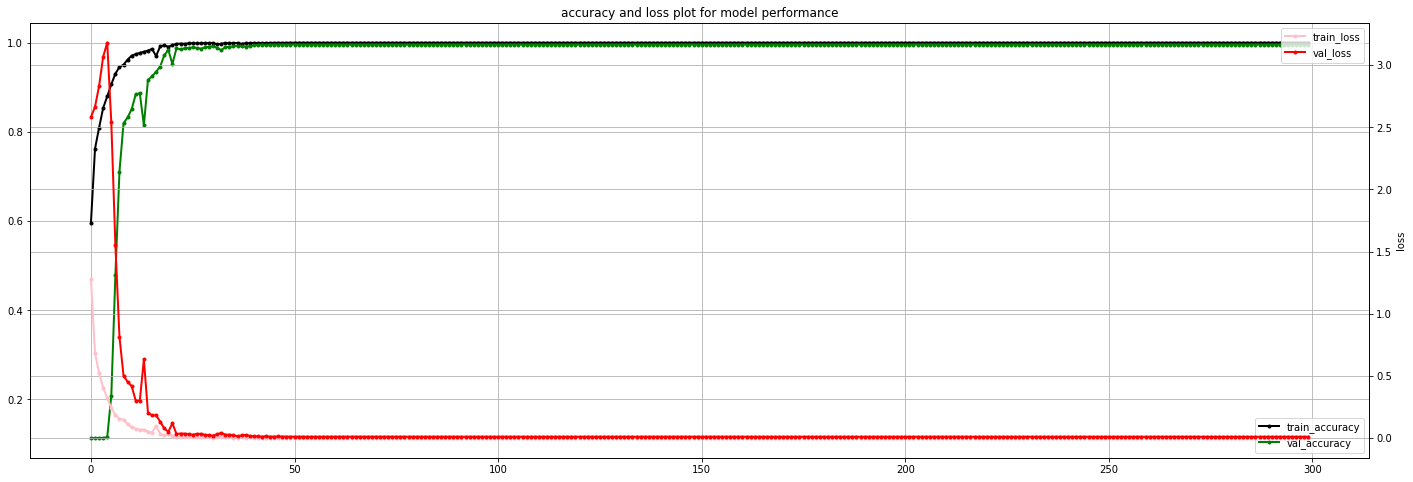

In [ ]:
plot_accuracy_loss_curve(history_att, None, use_attention = use_attention)

In [ ]:
model_att = reload_model(folder_path, use_attention, P_S)

In [ ]:
y_pred = np.argmax(model_att.predict(x_test), axis = 1)

62/62 [==============================] - 3s 19ms/step


In [ ]:
y_pred.shape, y_test.shape

((1963,), (1963,))

In [ ]:
filepath1 = folder_path +"/With_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " performance.txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a")) 
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results) 
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy) 
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)

 Confusion Matrix : 
[[219   0   0   0   0   0   0   0   0   0   0   0   4]
 [  1  41   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  64   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 113   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  87   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  58   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 251   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0  59   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0  62   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 135   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 344   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0 134   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 388]]
 Report :  
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       223
           1       0.98      0.98      0.98        42
           2       1.00      1.00      1.00        64
           3       1.00      1.00 

In [ ]:
y_test = y_test.reshape(y_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred = y_pred.astype(int)
y_combined = np.concatenate((y_test,y_pred),axis=1)

filepath1 = folder_path +"/With_Attention/"+str(train_percent)+"%_resNet_ps"+str(P_S)+".csv"

#img_path = folder_path + "Results/without_corr_"+ str(train_percent) + "%_SAresnet_ps_" +str(P_S) + ".csv"
 #filepath_1 = "/content/drive/My Drive/m_p/CNN Models Comparitive Study/372 band/Simple Models/Results/
np.savetxt(filepath1, y_combined, delimiter=",")

In [ ]:
import gc
gc.collect()

1757

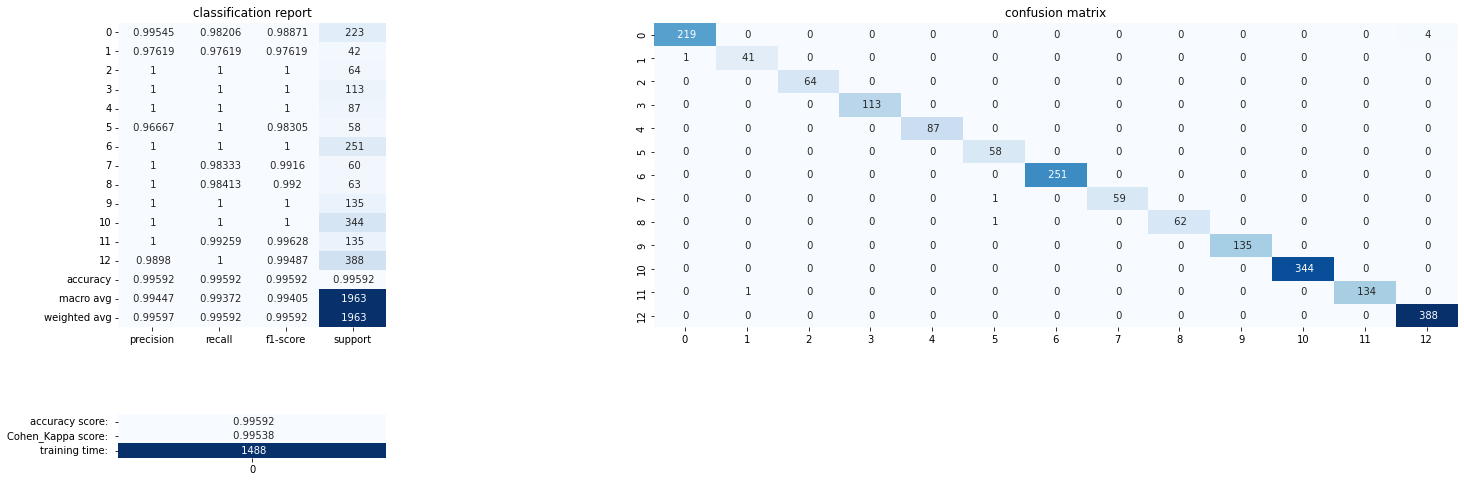

In [ ]:
performance_meausures(y_test, y_pred, tt, use_attention = use_attention, folder_path = folder_path, P_S = P_S)

In [ ]:
y_hat = predict_image(model_att, padded_x, H, W, B, P_S)

y_hat = y_hat.reshape((H,W))
a_c = np.unique(y_hat,return_counts=True)
print(a_c)
print(a_c,file=open(filepath1,"a"))

img_path_att = folder_path + "/With_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " predicted_image.png"
spectral.save_rgb(img_path_att, y_hat, colors = spectral.spy_colors)

35/35 [==============================] - 1s 16ms/step
image predicted ███████████████████████ 50%
35/35 [==============================] - 1s 16ms/step
image predicted ██████████████████████████████████████████████ 100%
total time taken is: 13.0 min 40.13653016090393 sec.
shape of predicted image is:  (1101, 566)
(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]), array([138186,   8693,   6031,  16045,  14584,  43163,  25848,  12187,
        16289,  15071, 114032,  49091, 163946]))


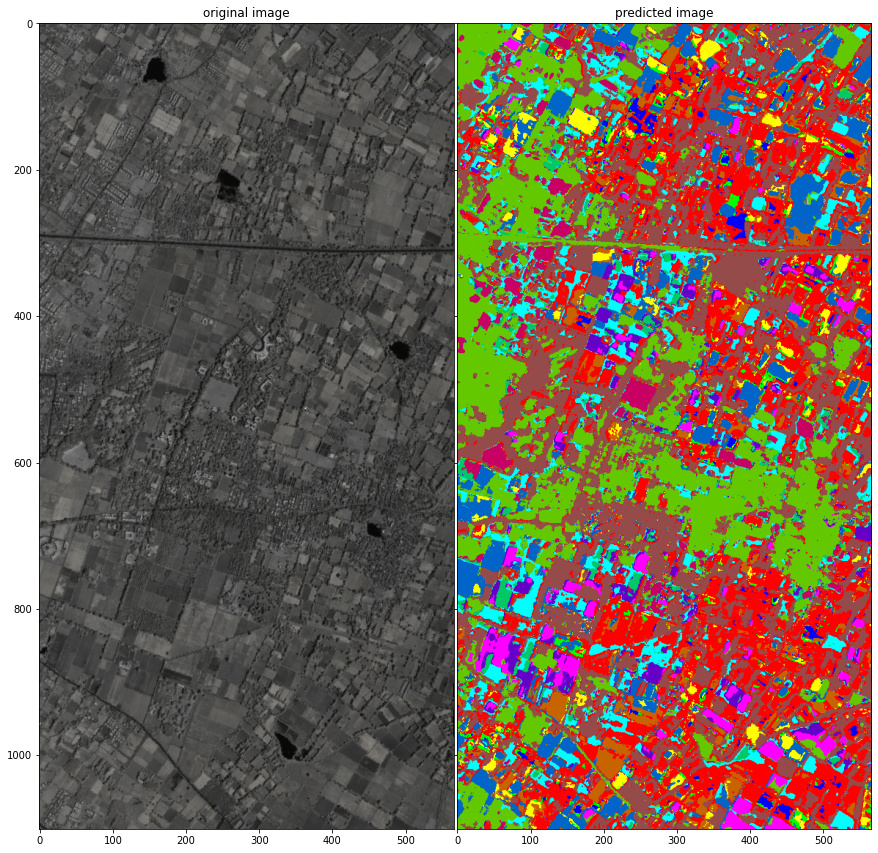

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex = True, sharey = True, figsize = (12, 12))
original_image = plt.imread("/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Approximate RGB Image.png")
ax1.imshow(original_image)
ax1.set_title("original image")

img = plt.imread(img_path_att)
ax2.imshow(img)
ax2.set_title("predicted image")
plt.tight_layout(pad = 0, h_pad = 0, w_pad = 0)
plt.show()

## **Without Attention**

In [ ]:
use_attention = False
folder_path = "/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/ResNet"

In [ ]:
model, history, tt = build_compile_and_train_model(x_train, y_train, x_test, y_test, folder_path = folder_path, use_pearson_corr = use_pearson_corr, 
                                               use_attention = use_attention, batch_size = 128, epochs = epochs )

You are not using attention mechanism.......
compiling done successfully.......
starting the training phase....

Epoch 1: LearningRateScheduler setting learning rate to 0.010000000000000002.
Epoch 1/300
46/46 [==============================] - ETA: 0s - loss: 1.0787 - accuracy: 0.6441
Epoch 1: val_accuracy improved from -inf to 0.12736, saving model to /content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/ResNet/Without_Attention/75% ps_7 ResNet.hdf5
46/46 [==============================] - 11s 62ms/step - loss: 1.0787 - accuracy: 0.6441 - val_loss: 2.4082 - val_accuracy: 0.1274 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999751608979677.
Epoch 2/300
46/46 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.7846
Epoch 2: val_accuracy improved from 0.12736 to 0.18034, saving model to /content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/ResNet/Without_At

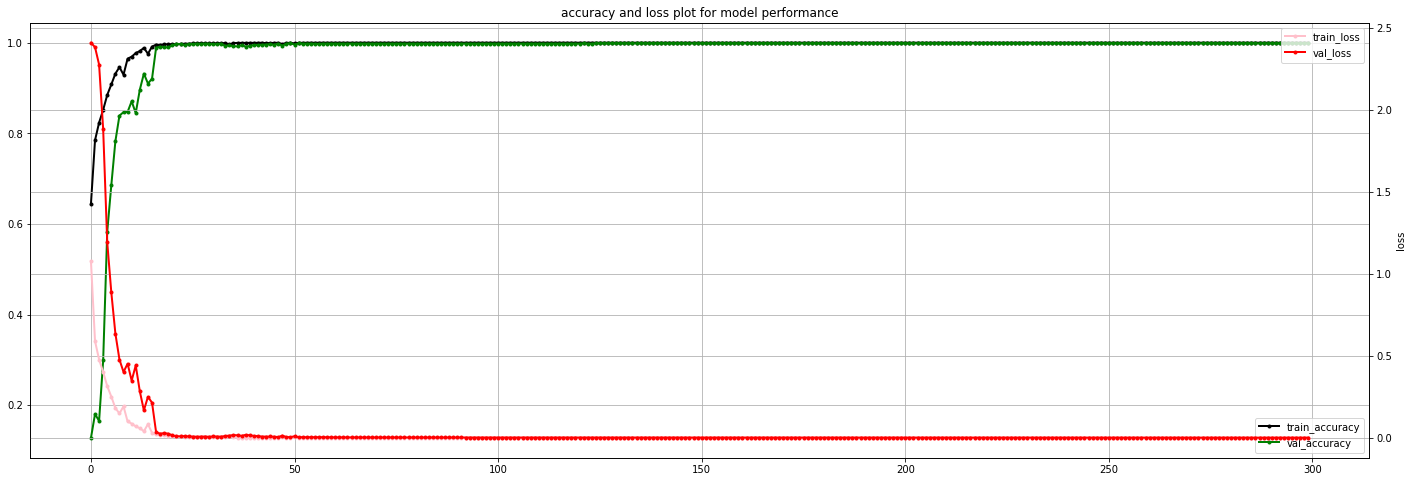

In [ ]:
plot_accuracy_loss_curve(history, None, use_attention = use_attention)

In [ ]:
model = reload_model(folder_path, use_attention, P_S)

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis = 1)

62/62 [==============================] - 1s 5ms/step


In [ ]:
filepath1 = folder_path +"/Without_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " performance.txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a")) 
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results) 
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy) 
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)

 Confusion Matrix : 
[[221   0   0   0   0   0   0   0   0   0   0   0   2]
 [  0  41   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0  64   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 113   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  87   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  58   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 251   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  60   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  63   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 135   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 344   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 135   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 388]]
 Report :  
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       223
           1       1.00      0.98      0.99        42
           2       1.00      1.00      1.00        64
           3       1.00      1.00 

In [ ]:
y_test = y_test.reshape(y_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred = y_pred.astype(int)
y_combined = np.concatenate((y_test,y_pred),axis=1)

filepath1 = folder_path +"/Without_Attention/"+str(train_percent)+"%_resNet_ps"+str(P_S)+".csv"

#img_path = folder_path + "Results/without_corr_"+ str(train_percent) + "%_SAresnet_ps_" +str(P_S) + ".csv"
 #filepath_1 = "/content/drive/My Drive/m_p/CNN Models Comparitive Study/372 band/Simple Models/Results/
np.savetxt(filepath1, y_combined, delimiter=",")

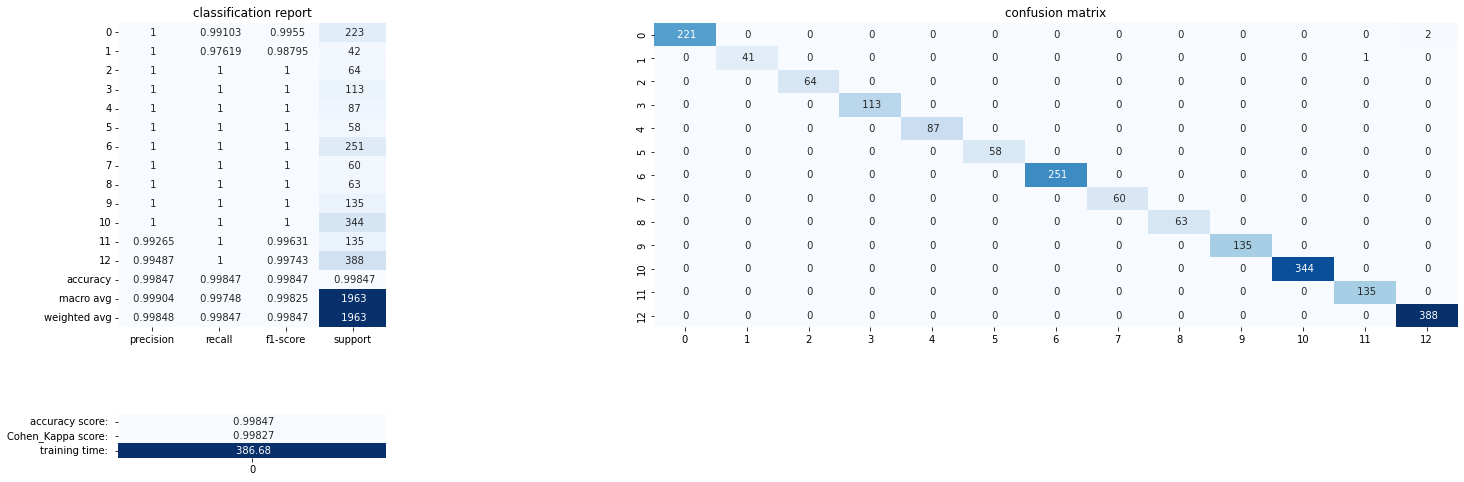

In [ ]:
performance_meausures(y_test, y_pred, tt, use_attention = use_attention, folder_path = folder_path, P_S = P_S)

In [ ]:
y_hat = predict_image(model, padded_x, H, W, B, P_S)

y_hat = y_hat.reshape((H,W))
a_c = np.unique(y_hat,return_counts=True)
print(a_c)


img_path = folder_path + "/Without_Attention/"+ str(train_percent) + "% ps_" + str(P_S) + " predicted_image.png"
spectral.save_rgb(img_path, y_hat, colors = spectral.spy_colors)

35/35 [==============================] - 0s 5ms/step
image predicted ███████████████████████ 50%
35/35 [==============================] - 0s 7ms/step
image predicted ██████████████████████████████████████████████ 100%
total time taken is: 9.0 min 12.378159284591675 sec.
shape of predicted image is:  (1101, 566)
(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]), array([116392,   6078,   8949,  23830,  30667,  34992,  28480,  13105,
        19366,  21321, 109433,  50509, 160044]))


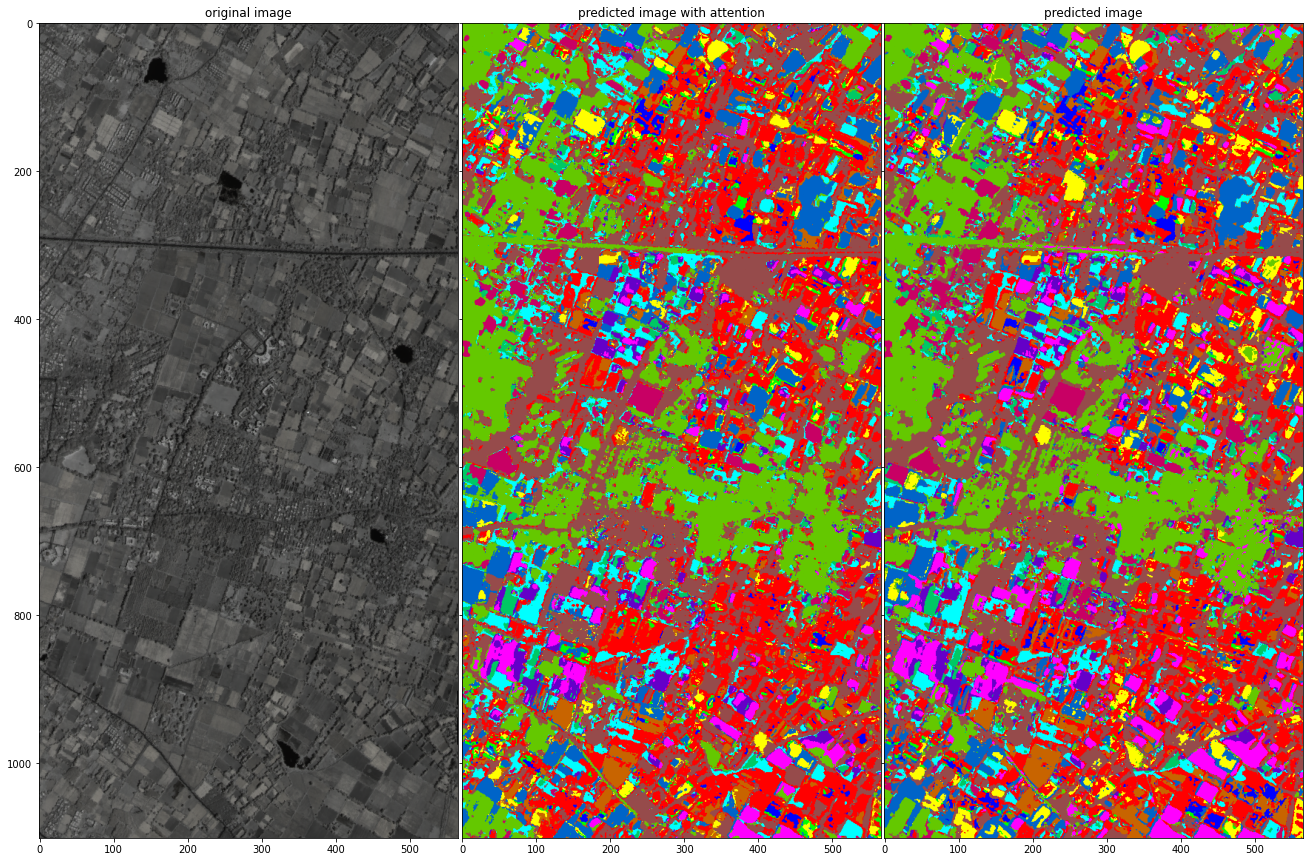

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex = True, sharey = True, figsize = (18, 12))
original_image = plt.imread("/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Approximate RGB Image.png")
ax1.imshow(original_image)
ax1.set_title("original image")

img_att = plt.imread(img_path_att)
ax2.imshow(img_att)
ax2.set_title("predicted image with attention")

img = plt.imread(img_path)
ax3.imshow(img)
ax3.set_title("predicted image")
plt.tight_layout(pad = 0, h_pad = 0, w_pad = 0)
plt.show()

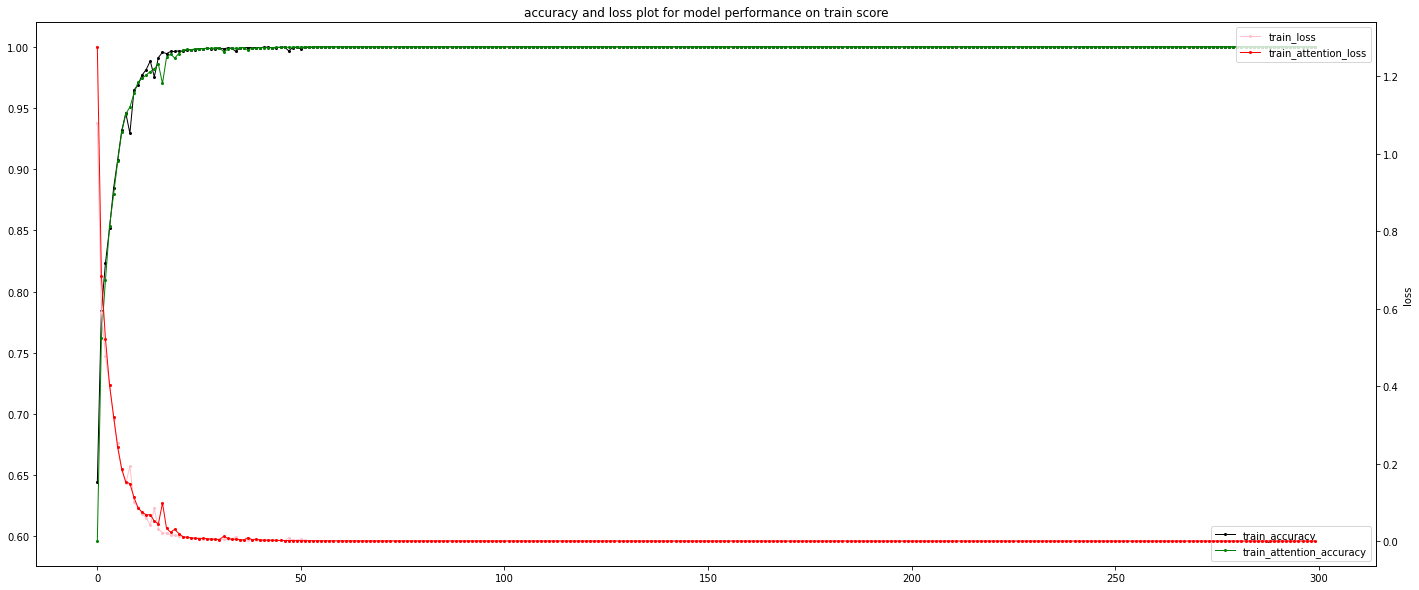

In [ ]:
plot_comparision_plot(history, history_att, train_or_val = 'train', folder_path = None)

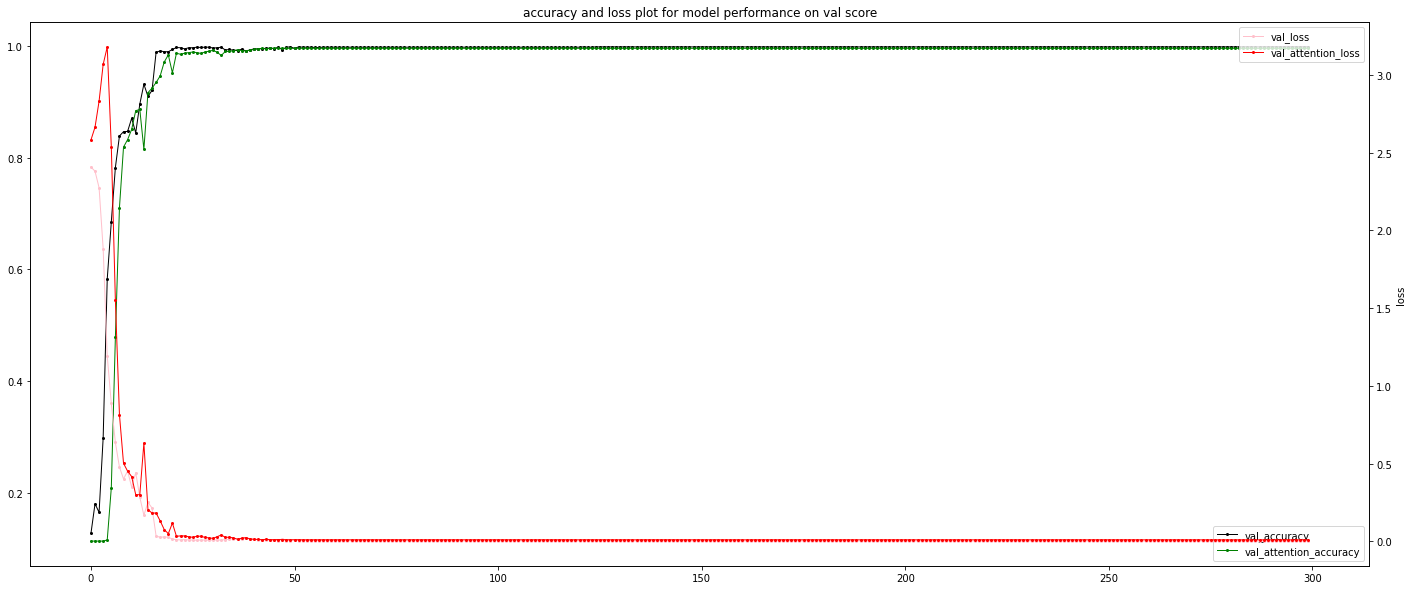

In [ ]:
plot_comparision_plot(history, history_att, train_or_val = 'val', folder_path = None)